In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.python.framework import ops
import imghdr
import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib
from google.protobuf import text_format
import cv2

import os
import time
import math
from random import shuffle

print(tf.__version__)

1.12.0


In [2]:
class TrainingExample:
    def __init__(self):
        self.path     = ''
        self.numfaces = 0
        
        self.encoding = np.zeros((7, 7, 7))
        self.encoding[..., 6] = 1
        
        self.original_width  = 0.0
        self.original_height = 0.0
        
        self.width  = 448.0
        self.height = 448.0
        
    def reshapeCoords(self, originalDimensionsW, originalDimensionsH, x, y, w, h):
        self.original_width  = originalDimensionsW
        self.original_height = originalDimensionsH
        
        scaleWidth  = self.width  / float(originalDimensionsW)
        scaleHeight = self.height / float(originalDimensionsH)
        
        rx = x * scaleWidth
        ry = y * scaleHeight
        rh = h * scaleWidth
        rw = w * scaleHeight
        
        #if scaleWidth > 2.0 or scaleHeight > 2.0 or scaleWidth < 0.5 or scaleHeight < 0.5:
        #    return None
        #else:
        return rx, ry, rh, rw
        
    def setBoxNum(self, x, y, w, h):
        x = float(x) + (float(w) / 2.0)
        y = float(y) + (float(h) / 2.0)
        
        width  = float(w) / 2
        height = float(h) / 2
        
        boxX = math.floor(float(x) / 64.0)
        boxY = math.floor(float(y) / 64.0)
        
        if boxX > 6 or boxY > 6:
            return
        
        adjustedX = float((x - (boxX * 64.0)) / 64.0 )
        adjustedY = float((y - (boxY * 64.0)) / 64.0 )
        
        adjustedWidth  = float(w / self.width )# + (10.0 / self.width )
        adjustedHeight = float(h / self.height) + (10.0 / self.height)
        
        self.encoding[boxX][boxY][0] = 1
        self.encoding[boxX][boxY][1] = adjustedX
        self.encoding[boxX][boxY][2] = adjustedY
        self.encoding[boxX][boxY][3] = adjustedWidth
        self.encoding[boxX][boxY][4] = adjustedHeight
        self.encoding[boxX][boxY][5] = 1
        self.encoding[boxX][boxY][6] = 0
        
    def print(self):
        print(self.path)
        print(self.numfaces)
        print(self.encoding)

In [3]:
gd_file = './wider_face_train_bbx_gt.txt'
lines = []
with open(gd_file) as f:
    while True:
        line = f.readline()
        if line:
            lines.append(line)
        else:
            break
        
f.close()

In [17]:
original_img = cv2.imread('../data/widerfaces/0--Parade/0_Parade_marchingband_1_5.jpg')

light_img = original_img.copy()
dark_img = original_img.copy()

h, w, c = light_img.shape

color_bgra = (255, 255, 255)
color_dark = (0, 0, 0)

overlay      = np.full((h, w, 3), color_bgra, dtype='uint8')
overlay_dark = np.full((h, w, 3), color_dark, dtype='uint8')

cv2.addWeighted(overlay,      0.5, light_img, 0.5, 0, light_img)
cv2.addWeighted(overlay_dark, 0.5, dark_img,  0.5, 0, dark_img )

cv2.imwrite('light.jpg', light_img)
cv2.imwrite('dark.jpg', dark_img)
cv2.imwrite('original.jpg', original_img)

True

In [4]:
examples = []

i = 0

color_light = (255, 255, 255)
color_dark  = (0, 0, 0)

while i < len(lines):
    filename = lines[i    ]
    numfaces = lines[i + 1]
    
    filename = '../data/widerfaces/' + filename
    filename = filename.replace('\n', '')
    numfaces = numfaces.replace('\n', '')
    img      = cv2.imread(filename)

    originalHeight, originalWidth, c = img.shape
    
    i+=2
    
    t          = TrainingExample()
    t.path     = filename
    t.numfaces = numfaces
    overScaled = False
    
    for face in range(int(numfaces)):
        coordinates = lines[i]
        coordinates = coordinates.replace('\n', '')
        splitCoordinates = coordinates.split(' ')

        x = float(splitCoordinates[0])
        y = float(splitCoordinates[1])
        h = float(splitCoordinates[2])
        w = float(splitCoordinates[3])

        r = t.reshapeCoords(originalWidth, originalHeight, x, y, h, w)
        if r is not None:
            t.setBoxNum(r[0], r[1], r[2], r[3])
        else:
            overScaled = True
        i += 1

    if not overScaled and originalHeight > 448 and originalWidth > 448:    
        examples.append(t)
        
print(len(examples))

12680


In [5]:
def getEncodingInformation(encoding):
    pc      = encoding[..., :1]
    boxes   = encoding[..., 1:5]
    softmax = encoding[..., -2:7]
    
    return pc, boxes, softmax

In [6]:
def visualize_bounding_box(image_path, encoding):
    print(image_path)
    pc, boxes, softmax = getEncodingInformation(encoding)
    
    max_c = -1.0
    
    img = cv2.imread(image_path)
    img = cv2.resize(img, (448, 448))

    for i in range(pc.shape[0]):
        for j in range(pc.shape[1]):
            cur_pc      = pc     [i, j]
            cur_box     = boxes  [i, j]
            cur_softmax = softmax[i, j]
            
            p = np.argmax(cur_softmax)
            
            if p == 0 and cur_pc > 0.7:
                x      = 0 if cur_box[0] < 0 else int(cur_box[0] * 64.0 + (i * 64.0))
                y      = 0 if cur_box[1] < 0 else int(cur_box[1] * 64.0 + (j * 64.0))
                width  = 0 if cur_box[2] < 0 else int(cur_box[2] * 448.0)
                height = 0 if cur_box[3] < 0 else int(cur_box[3] * 448.0)
            
                cv2.rectangle(img, (x - width, y - height), (x + width, y + height), (0, 255, 0), 2)
                
    plt.imshow(img)

../data/widerfaces/0--Parade/0_Parade_Parade_0_605.jpg


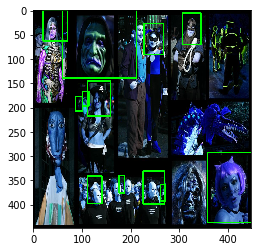

In [26]:
visualize_bounding_box(examples[110].path, examples[110].encoding)

In [7]:
#How many anchor boxes should be associated with each cell, one is probly not enough, maybe 5? experiment? 
#non_max_suppression will likely exclude most; needed if we only have one class?

def create_placeholders():
    x = tf.placeholder(shape = [None, 480, 720, 3   ], dtype = 'float', name = 'input'                )
    y = tf.placeholder(shape = [None, 24, 16, 7     ], dtype = 'float', name = 'ground_truth_encoding')
    
    return x, y

In [8]:
def initialize_parameters():
    W1  = tf.get_variable('W1' , [3, 3, 3, 3], initializer=tf.contrib.layers.variance_scaling_initializer())
    W2  = tf.get_variable('W2' , [3, 3, 3, 4], initializer=tf.contrib.layers.variance_scaling_initializer())
    W3  = tf.get_variable('W3' , [2, 2, 4, 4], initializer=tf.contrib.layers.variance_scaling_initializer())
    W4  = tf.get_variable('W4' , [2, 2, 4, 4], initializer=tf.contrib.layers.variance_scaling_initializer())
    W5  = tf.get_variable('W5' , [2, 2, 4, 4], initializer=tf.contrib.layers.variance_scaling_initializer())
    W6  = tf.get_variable('W6' , [2, 2, 4, 7], initializer=tf.contrib.layers.variance_scaling_initializer())
    
    parameters = {'W1'  : W1,
                  'W2'  : W2,
                  'W3'  : W3, 
                  'W4'  : W4, 
                  'W5'  : W5,
                  'W6'  : W6
                 }
    
    return parameters

In [9]:
#24, 16, 7

ops.reset_default_graph()


random_input = np.random.rand(32, 720, 480, 3)
random_input = tf.cast(random_input, tf.float32)

w_random_1   = np.random.rand(3, 3, 3, 3)
w_random_2   = np.random.rand(3, 3, 3, 4)
w_random_3   = np.random.rand(2, 2, 4, 4)
w_random_4   = np.random.rand(2, 2, 4, 4)
w_random_5   = np.random.rand(2, 2, 4, 7)

z_rand = tf.nn.conv2d(random_input, w_random_1, strides = [1, 2, 2, 1], padding='VALID')
z_rand = tf.nn.conv2d(z_rand      , w_random_2, strides = [1, 2, 2, 1], padding='VALID')
z_rand = tf.nn.conv2d(z_rand      , w_random_3, strides = [1, 2, 2, 1], padding='VALID')

z_rand = tf.nn.max_pool(z_rand, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='VALID')

z_rand = tf.nn.conv2d(z_rand      , w_random_4, strides = [1, 2, 2, 1], padding='VALID')
z_rand = tf.nn.conv2d(z_rand      , w_random_4, strides = [1, 1, 1, 1], padding='VALID' )

z_rand = tf.nn.max_pool(z_rand, ksize = [1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

z_rand = tf.nn.conv2d(z_rand      , w_random_5, strides = [1, 2, 2, 1], padding='VALID')

z_rand = tf.layers.flatten(z_rand)

z_rand = tf.layers.dense(z_rand, 250, activation = tf.nn.elu)
z_rand = tf.layers.dense(z_rand, 1000, activation = tf.nn.elu)
z_rand = tf.layers.dense(z_rand, 2688, activation = tf.nn.sigmoid)

z_rand = tf.reshape(z_rand, (-1, 24, 16, 7))

print(z_rand.shape)

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
z_rand_out = sess.run(z_rand)

z_rand_out.shape

(32, 24, 16, 7)


(32, 24, 16, 7)

In [10]:
def flat_layer(layer_input, kp = False):
    z = tf.layers.dense(inputs=layer_input, units = 2000, activation=tf.nn.elu)
    z = tf.layers.dropout(inputs=z, rate=0.5, training=kp)
    
    return z

In [11]:
def conv_layer(layer_input, parameters, num_layer, strides, kp, padding='VALID'):
    W = parameters['W' + str(num_layer)]
    
    z = tf.nn.conv2d(layer_input, W, strides = strides, padding = padding)
    z = tf.layers.batch_normalization(z, momentum=0.9, training = kp)
    z = tf.nn.relu(z)
    
    return z

In [12]:
def max_pool_layer(layer_input, ksize, strides, padding='NONE'):
    z = tf.nn.max_pool(layer_input, ksize = ksize, strides = strides, padding = padding)
    return z

In [13]:
def filter_boxes(box_confidence, boxes, box_class_probs, threshhold = 0.5):
    box_scores       = np.multiply(box_confidence, box_class_probs)
    
    box_classes      = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max   (box_scores, axis=-1)
    
    filtering_mask = K.greater_equal(box_class_scores, threshold)
    
    scores  = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes   = tf.boolean_mask(boxes           , filtering_mask)
    classes = tf.boolean_mask(box_classes     , filtering_mask)
    
    return scores, boxes, classes

In [14]:
def scale_bounding_box(originalX, originalY, orginalW, originalH, newW, newH):
    widthScale  = originalW / newW
    heightScale = originalH / newW
    
    scaledX = originalX * widthScale
    scaledY = originalY * heightScale

In [15]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 1, iou_threshold = 0.5):
    max_boxes_tensor = tf.variable(max_boxes, dtype='int32')              # tensor to be used in tf.image.non_max_suppression()
    tf.get_session().run(tf.variables_initializer([max_boxes_tensor]))    # initialize variable max_boxes_tensor

    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold=iou_threshold)

    scores  = tf.gather(scores , nms_indices)
    boxes   = tf.gather(boxes  , nms_indices)
    classes = tf.gather(classes, nms_indices)
    
    return scores, boxes, classes

In [16]:
def yolo_eval(encoding):
    confidence, boxes, probs = get_outputs             (encoding                )
    scores, boxes, classes   = yolo_filter_boxes       (confidence, boxes, probs)
    scores, boxes, classes   = yolo_non_max_suppression(scores, boxes, classes  )
    
    return scores, boxes, classes

In [17]:
def getImages(examples, batch, batch_size):
    images = []
    
    start = batch       * batch_size
    end   = (batch + 1) * batch_size
    
    if end > len(examples):
        end = len(examples)
    
    subset = examples[start:end]
    
    for example in subset:
        img   = cv2.imread(example.path)
        img   = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img   = cv2.resize(img, (720, 480))
        data  = np.array(img)
        #data  = data.flatten()
        
        data = data / 255
        
        images.append(data)
    
    return images

In [18]:
def getEncodings(examples, batch, batch_size):
    encodings = []
    
    start = batch       * batch_size
    end   = (batch + 1) * batch_size

    if end > len(examples):
        end = len(examples)
    
    subset = examples[start:end]
    
    for example in subset:
        encodings.append(example.encoding)
        encodings.append(example.encoding)
        encodings.append(example.encoding)

    return encodings

In [19]:
def get_cost(labels, outputs):
    
    positive_labels = tf.equal(labels[..., 0], 1.0)
    negative_labels = tf.equal(labels[..., 0], 0.0)
    
    pos_labels  = tf.boolean_mask(labels, positive_labels)
    pos_outputs = tf.boolean_mask(outputs, positive_labels)
    
    neg_labels  = tf.boolean_mask(labels, negative_labels)
    neg_outputs = tf.boolean_mask(outputs, negative_labels)
    
    cost = tf.reduce_sum(0.5 * tf.losses.mean_squared_error(neg_labels[..., 0], neg_outputs[..., 0]) + tf.losses.mean_squared_error(pos_labels[..., 0], pos_outputs[..., 0]) + tf.losses.mean_squared_error(pos_outputs[..., -2:7], pos_labels[..., -2:7]) + tf.losses.mean_squared_error(pos_outputs[..., 1:5], pos_labels[..., 1:5]))

    return cost

In [20]:
def model_yolo(training_examples, test_examples, learning_rate = 1e-4, num_epochs = 5, batch_size = 32):
    ops.reset_default_graph()
    m = len(training_examples)
    
    batch_images, batch_encodings = create_placeholders()
    parameters                    = initialize_parameters()
    kp                            = tf.placeholder(dtype='bool', name='kp')
    
    output = conv_layer    (batch_images, parameters, 1, [1, 2, 2, 1], kp)
    output = conv_layer    (output      , parameters, 2, [1, 2, 2, 1], kp)
    output = conv_layer    (output      , parameters, 3, [1, 2, 2, 1], kp)
    output = tf.nn.max_pool(output, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='VALID')
    
    output = conv_layer    (output      , parameters, 4, [1, 2, 2, 1], kp)
    output = conv_layer    (output      , parameters, 5, [1, 1, 1, 1], kp)
    output = tf.nn.max_pool(output, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='VALID')
    
    output = conv_layer    (output      , parameters, 6, [1, 2, 2, 1], kp)
    
    output = tf.layers.flatten(output)
    
    output = tf.layers.dense(output, 250 , activation = tf.nn.elu)
    output = tf.layers.dense(output, 1000, activation = tf.nn.elu)
    output = tf.layers.dense(output, 2688, activation = tf.nn.sigmoid)

    output = tf.reshape(output, (-1, 24, 16, 7))

    cost, pos_labels, pos_outputs = get_cost(batch_encodings, output)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    saver = tf.train.Saver()
    
    init  = tf.global_variables_initializer()

    sess = tf.Session()
    sess.run(init)
    
    tf.train.write_graph(sess.graph.as_graph_def(), './tmp/input_model', 'input_yolo_graph.pbtxt', True)
    
    for epoch in range(num_epochs):    
        epoch_cost = 0
        num_batches = (int)(m / batch_size)
        shuffle(training_examples)
        for batch in range(num_batches):
            images    = getImages   (training_examples, batch, batch_size / 3)
            encodings = getEncodings(training_examples, batch, batch_size / 3)
            
            _, batch_cost = sess.run([optimizer, cost], feed_dict = { batch_images : images, batch_encodings : encodings, kp : True})
            epoch_cost += batch_cost / num_batches
        
        if epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            print ()
            print ("---------------------------------------------")
            print ()
            saver.save(sess, './tmp/yolo.ckpt')
    
    test_images    = []
    test_encodings = []
    
    for example in test_examples:
        img   = cv2.imread(example.path)
        img   = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img   = cv2.resize(img, (720, 480))
        data  = np.array(img)
        
        data = data / 255
        
        test_images.append(data)
        
    for example in test_examples:
        test_encodings.append(example.encoding)

    test_out = sess.run([output], feed_dict = { batch_images : test_images, batch_encodings : test_encodings, kp : False })
    return test_out

In [ ]:
train_examples = examples[:9000]
test_examples = examples[-285:]

test_out = model_yolo(train_examples, test_examples, num_epochs=100, batch_size = 32)

In [ ]:
squeeze_test_out = test_out[0]

In [ ]:
test_encoding = squeeze_test_out[2]

np.shape(test_encoding)

In [ ]:
img   = cv2.imread(test_examples[5].path)

plt.imshow(img)

In [ ]:
test_path = test_examples[20].path
test_encoding = squeeze_test_out[20]

visualize_bounding_box(test_path, test_encoding)

In [ ]:
path = 'C:/facial_recognition/inputs/widerfaces/0--Parade/0_Parade_Parade_0_123.jpg'
encoding = np.reshape(out_encoding, (72, 48, 7))
print(encoding.shape)
visualize_bounding_box(path, encoding)

In [ ]:
path = 'C:/facial_recognition/inputs/widerfaces/0--Parade/0_Parade_Parade_0_123.jpg'
img  = cv2.imread(path)
plt.imshow(img)
img  = cv2.resize(img, (720, 480))
data = np.array(img)
data = data.flatten()

data = data / 255

data = data.reshape((1, 720 * 480 * 3))

saver = tf.train.import_meta_graph('./tmp/yolo.ckpt.meta')

with tf.Session() as sess:
    saver.restore(sess, './tmp/yolo.ckpt')
    encoding = sess.run('output:0', feed_dict={'input:0' : data, 'kp:0' : False})
    print(encoding[0, 24, 27])
    print(encoding.shape)
    encoding = np.reshape(encoding, (72, 48, 7))
    visualize_bounding_box(path, encoding)

TRANSFER LEARNING

In [21]:
import sys

sys.path.append('C:/modules/tensornets/')

In [22]:
import tensornets as nets

In [23]:
def create_resnet_placeholders():
    x = tf.placeholder(shape = [None, 224, 224, 3], dtype = 'float', name = 'input_image'          )
    y = tf.placeholder(shape = [None, 7, 7, 7    ], dtype = 'float', name = 'ground_truth_encoding')
    
    return x, y

In [24]:
def getResImages(examples, batch, batch_size, model):
    images = []
    
    start = batch       * batch_size
    end   = (batch + 1) * batch_size
    
    if end > len(examples):
        end = len(examples)
    
    subset = examples[start:end]
    
    for example in subset:
        img   = cv2.imread(example.path)    
        img   = cv2.resize(img, (224, 224))
        
        h, w, c = img.shape
        
        light_img = img.copy()
        dark_img  = img.copy()
        
        color_light = (255, 255, 255)
        color_dark  = (0, 0, 0)

        overlay      = np.full((h, w, 3), color_light, dtype='uint8')
        overlay_dark = np.full((h, w, 3), color_dark , dtype='uint8')

        cv2.addWeighted(overlay,      0.5, light_img, 0.5, 0, light_img)
        cv2.addWeighted(overlay_dark, 0.5, dark_img,  0.5, 0, dark_img )
        
        images.append(img)
        images.append(overlay)
        images.append(overlay_dark)
    
    return images

In [30]:
def transfer_model_yolo(training_examples, learning_rate = 1e-4, num_epochs = 5, batch_size = 32):
    ops.reset_default_graph()
    m = len(training_examples)
    
    batch_images, batch_encodings = create_resnet_placeholders()
    kp                            = tf.placeholder(dtype='bool', name='kp')
    
    res_model = nets.ResNet50(batch_images, is_training=True)
    output = res_model.get_outputs()[158]
        
    with tf.variable_scope('training_vars'):
        output = tf.layers.dense  (output, 1500, activation = tf.nn.elu)
        output = tf.layers.dropout(output, training=kp)
        #output = tf.layers.dense  (output, 1000, activation = tf.nn.elu)
        #output = tf.layers.dropout(output, training=kp)
        #output = tf.layers.dense  (output, 500, activation = tf.nn.elu)
        #output = tf.layers.dropout(output, training=kp)
    
        output = tf.layers.dense(output, 343, activation = tf.nn.sigmoid)
        output = tf.reshape(output, (-1, 7, 7, 7), name='final_output')
    
    training_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'training_vars')
    
    cost = get_cost(batch_encodings, output)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)#, var_list=training_vars)
    
    saver = tf.train.Saver()
    
    init  = tf.global_variables_initializer()

    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))# as sess:
    sess.run(init)
    sess.run(res_model.pretrained())
    
    tf.train.write_graph(sess.graph.as_graph_def(), './tmp/input_model', 'input_yolo_graph.pbtxt', True)
    
    for epoch in range(num_epochs):    
        epoch_cost = 0
        num_batches = (int)(m / batch_size)
        shuffle(training_examples)
        for batch in range(num_batches):
            images    = getResImages(training_examples, batch, batch_size, res_model)
            encodings = getEncodings(training_examples, batch, batch_size)
            
            _, batch_cost = sess.run([optimizer, cost], feed_dict = { batch_images : images, batch_encodings : encodings, kp : True})
            epoch_cost += batch_cost / num_batches
        
        if epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            print ()
            print ("---------------------------------------------")
            print ()
            saver.save(sess, './tmp/yolo.ckpt')

In [ ]:
train_examples = examples
#test_examples  = examples[-680: ]

transfer_model_yolo(train_examples, num_epochs=150, batch_size=8)

c:\deep_learning_workspace\deep_learning_env\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Cost after epoch 0: 0.311883

---------------------------------------------



In [ ]:
squeeze_test_out = to[0]

test_path = test_examples[3].path
test_encoding = squeeze_test_out[3]

visualize_bounding_box(test_path, test_encoding)

In [88]:
test_inputs = tf.placeholder(tf.float32, (None, 224, 224, 3))
actual_input = train_examples[0].path

In [89]:
test_input = nets.utils.load_img(actual_input, target_size=(224, 224))
test_input   = np.reshape(test_input, (-1, 224, 224, 3))

In [90]:
#model = nets.MobileNet50v2(test_inputs, is_training=False)

In [91]:
#test_input = model.preprocess(test_input)

In [92]:
ops.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./tmp/yolo.ckpt.meta')
    saver.restore(sess, './tmp/yolo.ckpt')
    graph = tf.get_default_graph()
    out = graph.get_tensor_by_name('training_vars/final_output:0')
    
    encoding = sess.run(out, feed_dict = { 'input_image:0' : test_input, 'kp:0' : False })
    

INFO:tensorflow:Restoring parameters from ./tmp/yolo.ckpt


In [93]:
sencoding = encoding[0]

../data/widerfaces/16--Award_Ceremony/16_Award_Ceremony_Awards_Ceremony_16_364.jpg


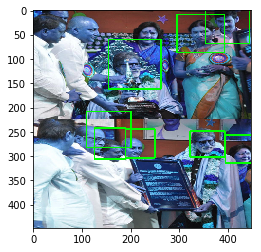

In [94]:
visualize_bounding_box(actual_input, sencoding)

In [ ]:
i = cv2.imread(test_examples[6].path)
plt.imshow(i)